# 2D elasticity

### Definition of problem
Governing partial differential equation for general elasticity reads
\begin{equation}
\mathrm{div}\boldsymbol{\sigma} + \mathbf{b} = \mathbf{0}
\end{equation}
supplemented by boundary conditions
\begin{equation}
\mathbf{u}(\mathbf{x}) = \bar{\mathbf{u}}, \forall \mathbf{x}\in\Gamma_u,
\end{equation}
\begin{equation}
\boldsymbol{\sigma}\cdot\mathbf{n}=\mathbf{f}, \forall \mathbf{x}\in\Gamma_f,
\end{equation}
where constitutive relation between stress tensor $\boldsymbol{\sigma}$ and strain tensor $\boldsymbol{\varepsilon}$ for linear elastic isotropic material is given by
\begin{equation}
\boldsymbol{\sigma}=\lambda\mathrm{tr}(\boldsymbol{\varepsilon})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}, \end{equation}
where $\lambda, \mu$ are Lame's constants. Further, strain is defined as symmetric gradient of displacement field $\mathbf{u}$ as
\begin{equation}
\boldsymbol{\varepsilon}=\frac{1}{2}\left(\nabla\mathbf{u}+\nabla^{\mathrm{T}}\mathbf{u}\right)
\end{equation}
and $\mathbf{b}$ and $\mathbf{f}$ represents volume forces and surface forces respectively.

For FEM solution, we need weak form of task. By testing $\delta\mathbf{u}$, integration over spatial domain and performing integration per partes, we obtain weak form:

Find $\mathbf{u}$ s.t.
\begin{equation}
\int_\Omega\boldsymbol{\sigma}:\delta\boldsymbol{\varepsilon}\ \mathrm{d}\Omega + \int_\Omega \mathbf{b}\cdot\delta\mathbf{u}\ \mathrm{d}\Omega + \int_{\Gamma_f}\mathbf{f}\cdot\delta\mathbf{u}\ \mathrm{d}\partial\Omega = 0, \forall \delta\mathbf{u}
\end{equation}
supplemented by
\begin{equation}
\mathbf{u}(\mathbf{x}) = \bar{\mathbf{u}}, \forall \mathbf{x}\in\Gamma_u,
\end{equation}
\begin{equation}
\delta\mathbf{u}(\mathbf{x}) = \mathbf{0}, \forall \mathbf{x}\in\Gamma_u.
\end{equation}


### Implementation


After importing dependencies we define several auxiliary functions. The first function define set of point which are on boundary and have $y=0$. Here x[] is triplet of spatial coordinates, so x[0] is $x$ coordinate, x[1] is $y$ and x[3] is $z$. Functions *epsilon* and *sigma* define strain and stress as function of displacement field $\mathbf{u}$. These functions are defined symbolically using several FEniCS objects or functions. Here is a short table of frequently used ones:

| FEniCS object | Description |
| -- | -- |
| fe.grad(u) | Gradient of function u |
| fe.div(u) | Divergence of function u |
| fe.dot(u, v) | Dot product between u and v |
| fe.inner(u, v) | Inner product between u and v |
| fe.Identity(d) | Identity tensor with dimension d |
| fe.sym(u) | Symmetric part of u |
| fe.dev(u) | Deviatoric part of u |
| fe.rot(u) | Rotation operator of u |
| .T | Transposition of tensor |

More possible operators can be found in https://fenicsproject.org/docs/ufl/1.6.0/ufl.html#ufl-package.

In [1]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)

Parameters of task are defined.

In [2]:
# --------------------
# Parameters
# --------------------
# Lame's constants
lmbda = 1.25
mu = 1

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
f_int = 0.0
b_int = 0.0
F_con = -3.0e-1

Structured simple rectangular mesh can be created by FEniCS object *RectangleMesh*. Mesh is generated using triangles oriented in right direction. 

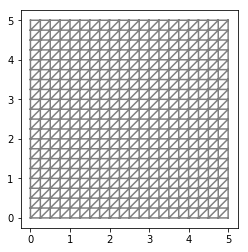

In [3]:
# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

fe.plot(mesh)
plt.show()

Orientation of triangles can be changed by adding *"left"* argument.

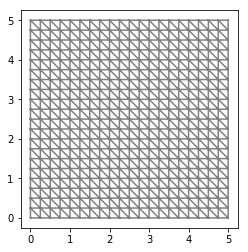

In [4]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "left"))
plt.show()

Other types of mesh are *"crossed"* and *"left/right"*.

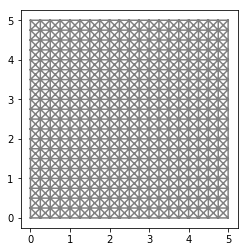

In [5]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "crossed"))
plt.show()

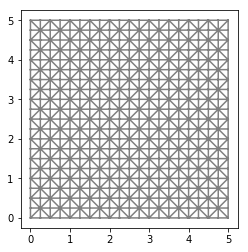

In [6]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "left/right"))
plt.show()

Definition of domain part where Neumann boundary conditions are prescribed. (TODO)

In [7]:
# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

In this example trial and test functions are vector functions therefore instead of operating on scalar space $V$ we must define function space $V\times V$ for 2D and $V\times V\times V$ for 3D. It is done by calling *VectorFunctionSpace* from FEniCS package.

In [8]:
# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

Vector function defined in this space must be defined using python tuple as

In [9]:
f = fe.Constant((0.0, f_int))
b = fe.Constant((0.0, b_int))

Dirichlet boundary conditions are defined the same way.

In [10]:
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

Or we can restrict displacements in one direction only. In this case, the first argument of *DirichletBC* is subspace of vector function space. For example following piece of code prescribes zero displacement in $y$-direction.

In [ ]:
bc = fe.DirichletBC(V.sub(1), 0.0, bottom)

Weak form is defined using pre-defined FEniCS operators as inner or dot product. Objects *dx* and *ds* represent integration domain. Three basic integration domains are implemented:

| FEniCS object | Description |
| -- | -- |
| fe.dx | Integration over domain volume |
| fe.ds | Integration over outer boundary |
| fe.dS | Integration over interal boundary |

Moreover integration domain accepts the optional argument which defines only part of domain. For example domain *fe.ds(1)* represents part of outer boundary which is labeled by integer 1. Such labeling was introduced above.

In [11]:
# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.dot(b, u_test)*fe.dx - fe.inner(f, u_test)*ds(1)

(JS: Vim, ze jsme se bavili o tom, ze bodova sila nema vyznam. Mozna bych to tu nechal kvůli ukazce toho jak to udelat, ale je to potreba dostatecne okomentovat.)

It is possible use *fe.solve(a==l, V, bc)* again. In the next code, we will introduce another solution that is useful when we need to access the system matrices directly. For this purposes FEniCS provides function *assembly_system* with three arguments: left hand side, right hand side, Dirichlet boundary conditions. This function returns assembled matrix of system *A_ass* and vector of right hand side *L_ass*.

In [12]:
# --------------------
# Solver
# --------------------
u = fe.Function(V)
A_ass, L_ass = fe.assemble_system(a, l, bc)

(TODO - Vymazat nebo nechat?)

In [13]:
# Dirac function load intensity
pointForce = fe.PointSource(V.sub(1), fe.Point((0.5*l_x, l_y)), F_con)
pointForce.apply(L_ass)

FEniCS provides overloaded function *solve* for solving linear system, which returns vector of displacements. Therefore we must use *u.vector()* as second argument. Function *u.vector()* returns vector of *u* function.

In [14]:
fe.solve(A_ass, u.vector(), L_ass)

1

### Post-process

Node values can be accessed by *.vector()* function. It returns iterable *PETScVector* object, so we can manipulate with nodal values. It is shown search for the highest value of displacement for example.

In [16]:
print(np.amax(u.vector()[:]))

0.0274336386774


Displacement is vector field and can not be plotted directly. We must specify scalar subspace for plotting.

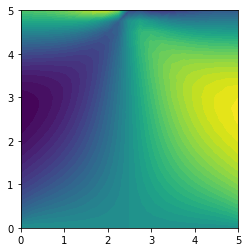

In [18]:
fe.plot(u.sub(0))
plt.show()

Second option is to call optional argument mode with value "displacement". Result is evident from picture below.

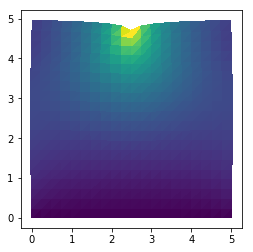

In [19]:
fe.plot(u, mode="displacement")
plt.show()

Stress can be plotted similarly, but it is second-order tensor, therefore we must specify scalar subspace by two indices. For example stress $\sigma_y$ is obtained by *sigma(u)[1,1]*:

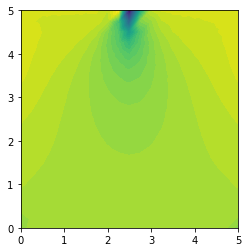

In [20]:
stress = sigma(u)
fe.plot(stress[1, 1])
plt.show()

This procedure is sufficient for plotting or for reuse sigma in another weak form. However, if we need to access stress nodal values, we must first project it into a suitable space. Displacement field live in *CG1*, so corresponding space for stress is *DG0* space. Moreover we must define *TensorFunctionSpace* because stress is second-order tensor.

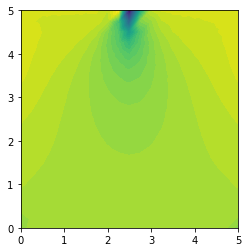

In [21]:
V0 = fe.TensorFunctionSpace(mesh, "DG", 0)
stress_1 = fe.project(stress, V0)
fe.plot(stress_1[1, 1])
plt.show()

<div class="alert alert-block alert-success">
    Projection of function $u\in V$ onto space $W$ is following variational problem:
    \begin{equation}
    \mathrm{Find}\,g\in W\,\mathrm{s.t.}\,\int_\Omega uv\ \mathrm{d}\Omega = \int_\Omega gv\ \mathrm{d}\Omega,\ \forall v\in W.
    \end{equation}
</div>

It can be useful tool, especially if we convert function into non-coresponding spaces. But stresses can be obtained from displacements by differentiation of basis function and projection can be unnecessarily expensive. More effective way is make projection element-wise. It can be done by following subroutine:

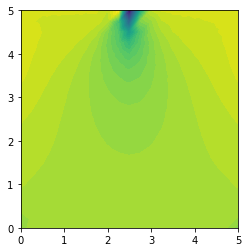

In [22]:
def local_project(fce, space):
    lp_trial, lp_test = fe.TrialFunction(space), fe.TestFunction(space)
    lp_a = fe.inner(lp_trial, lp_test)*fe.dx
    lp_L = fe.inner(fce, lp_test)*fe.dx
    local_solver = fe.LocalSolver(lp_a, lp_L)
    local_solver.factorize()
    lp_f = fe.Function(space)
    local_solver.solve_local_rhs(lp_f)
    return lp_f
stress_2 = local_project(stress, V0)
fe.plot(stress_1[1, 1])
plt.show()

### Code

0.0329497652377


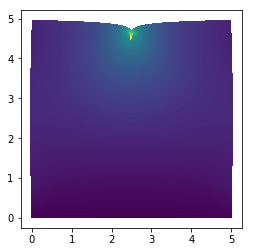

In [5]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.grad(u) + fe.grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
# Lame's constants
lmbda = 1.25
mu = 1

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 500, 500  # Number of elements

# Load
f_int = 0.0
b_int = 0.0
F_con = -3.0e-1

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
f = fe.Constant((0.0, f_int))
b = fe.Constant((0.0, b_int))

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.dot(b, u_test)*fe.dx - fe.inner(f, u_test)*ds(1)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
A_ass, L_ass = fe.assemble_system(a, l, bc)

# Dirac function load intensity
pointForce = fe.PointSource(V.sub(1), fe.Point((0.5*l_x, l_y)), F_con)
pointForce.apply(L_ass)

fe.solve(A_ass, u.vector(), L_ass)

print(np.amax(u.vector()[:]))

# --------------------
# Post-process
# --------------------
fe.plot(u, mode="displacement")
plt.show()

## TODO:

- Ukazka implementace 4-uhelnikovych prvku
- Vlozeni vlastni site
- Popis ruznych prostoru - CG, DG, ...